# Binary Classifier Notebook

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import set_config

set_config(display='diagram') 


TypeError: set_config() got an unexpected keyword argument 'display'

In [2]:

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Load the Data

In [3]:
data_folder = os.path.join("/Users/rsun/projects/data/datasets","titanic")

In [4]:
def load_csv_data(path,filename):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [5]:
df_raw = load_csv_data(data_folder,"train.csv")

In [6]:
df_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 2. Explore the Data

In [7]:
# create copy of data
df = df_raw.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Identify target variable
target_col = 'Survived'
ID_col = 'PassengerId'
y = df[target_col]

# Drop ID and Label from Data
drop_cols = ['Name','Ticket','Cabin']
drop_cols.append(target_col)
drop_cols.append(ID_col)

drop_cols

['Name', 'Ticket', 'Cabin', 'Survived', 'PassengerId']

In [9]:
df[target_col].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:


df.drop(drop_cols,axis=1,inplace=True)

df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify = y, random_state=42)

In [14]:
y_train.value_counts(normalize=True)

0    0.616573
1    0.383427
Name: Survived, dtype: float64

## 3. Prepare the Data

### Preprocess pipeline 2 - Using the ColumnsTransformer

In [15]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,3,male,NaN,0,0,56.4958,S
481,2,male,NaN,0,0,0.0000,S
527,1,male,NaN,0,0,221.7792,S
855,3,female,18.0,0,1,9.3500,S
801,2,female,31.0,1,1,26.2500,S


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer



num_pipeline2 = Pipeline([
        ("num_imputer", SimpleImputer(strategy="median")),
        # ('std_scaler',StandardScaler())
    ])



cat_pipeline2 = Pipeline([
        ("cat_imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(handle_unknown='ignore'))
    ])

In [17]:
column_trans = ColumnTransformer([
                ('num',num_pipeline2,make_column_selector(dtype_include=np.number)),    
                ('cat',cat_pipeline2,make_column_selector(dtype_include=['category','object']))
                ])



In [18]:
column_trans

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('num_imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0))],
                                          verbose=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7...
                                                  SimpleImputer(add_indic

In [19]:
def get_preprocessed_df(df,trans,fit_flag=False):
    
    if fit_flag:
        df_ = trans.fit_transform(df)
    else:
        df_ = trans.transform(df)
    
    num_cols = column_trans.transformers_[0][2]

    cat_cols_encoded = column_trans.transformers_[1][1]['cat_encoder'].get_feature_names(column_trans.transformers_[1][2])
    
    return pd.DataFrame(df_,
        columns=num_cols + list(cat_cols_encoded),
        index=df.index)

In [20]:
X_train_preprocessed = get_preprocessed_df(X_train,column_trans,fit_flag=True)

X_train_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
692,3.0,28.5,0.0,0.0,56.4958,0.0,1.0,0.0,0.0,1.0
481,2.0,28.5,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,1.0
527,1.0,28.5,0.0,0.0,221.7792,0.0,1.0,0.0,0.0,1.0
855,3.0,18.0,0.0,1.0,9.3500,1.0,0.0,0.0,0.0,1.0
801,2.0,31.0,1.0,1.0,26.2500,1.0,0.0,0.0,0.0,1.0


In [21]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
565,3,male,24.0,2,0,24.1500,S
160,3,male,44.0,0,1,16.1000,S
553,3,male,22.0,0,0,7.2250,C
860,3,male,41.0,2,0,14.1083,S
241,3,female,NaN,1,0,15.5000,Q


In [22]:
X_test_preprocessed = get_preprocessed_df(X_test,column_trans,fit_flag=False)

X_test_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
565,3.0,24.0,2.0,0.0,24.1500,0.0,1.0,0.0,0.0,1.0
160,3.0,44.0,0.0,1.0,16.1000,0.0,1.0,0.0,0.0,1.0
553,3.0,22.0,0.0,0.0,7.2250,0.0,1.0,1.0,0.0,0.0
860,3.0,41.0,2.0,0.0,14.1083,0.0,1.0,0.0,0.0,1.0
241,3.0,28.5,1.0,0.0,15.5000,1.0,0.0,0.0,1.0,0.0


## 4. Train a Baseline Model 

In [23]:
# RandomForest Baseline Model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)


In [24]:
# get the cross validation score
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train_preprocessed, y_train, 
                                scoring='roc_auc',cv=10)
forest_scores.mean()

0.859734666711411

In [25]:
import sklearn.metrics as metrics
def get_test_auc(clf,X_test,y_test):
    '''
    Get predicted score and calculate the auc
    '''
    y_pred = clf.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1])
    return metrics.auc(fpr, tpr)

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
def plot_roc_curve(fpr,tpr,title):
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % metrics.auc(fpr,tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def plot_roc_auc_comp(df,y,pred):
    '''func to plot auc curve chart compare the predictions in a dataframe
    df: dataframe has y and prediction/scores
    y: actural outcome
    pred: list of columns with scores
    example: plot_roc_auc_comp(df_scores,
                                y='target',
                                pred=['model1_score','model2_score']
                                )
    '''
    plt.figure(figsize = (6,6), dpi=120)
    for i in pred:
        tmp_df = df.dropna(subset = [i])
        tmp_fpr, tmp_tpr, tmp_threshold = metrics.roc_curve(tmp_df[y],tmp_df[i])
        tmp_auc = metrics.auc(tmp_fpr,tmp_tpr)
        plt.plot(tmp_fpr,
                 tmp_tpr,
                 lw=2,
                 label = '{0}(AUC = {1:0.4f})'.format(i,tmp_auc)
        )
    
    plt.plot([0,1],[0,1],color = 'red', lw=2, linestyle= '--')
    plt.axis('square')
    plt.xlim([-0.05,1])
    plt.ylim([0,1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC comparison')
    plt.legend(loc='lower right')
    plt.show()

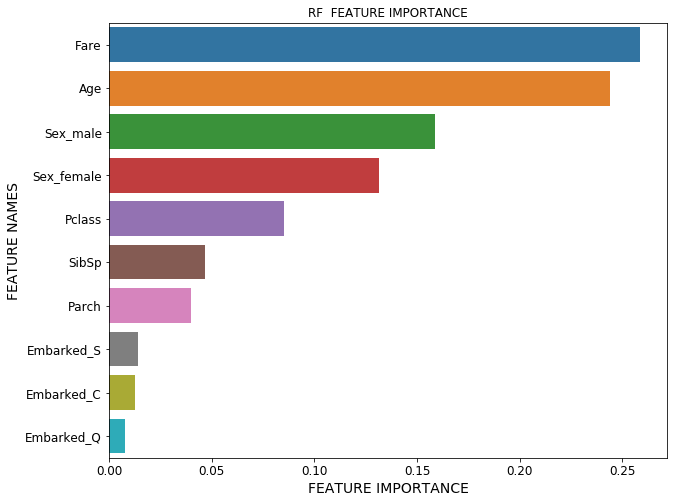

In [26]:
# feature importance
forest_clf.fit(X_train_preprocessed,y_train)

plot_feature_importance(forest_clf.feature_importances_,X_train_preprocessed.columns,"RF ")

In [27]:
get_test_auc(forest_clf,X_test_preprocessed,y_test)

0.8335968379446641

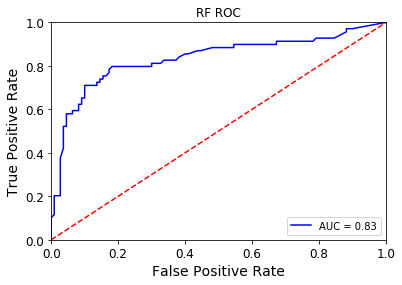

In [28]:
y_pred_baseline = forest_clf.predict_proba(X_test_preprocessed)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_baseline[:,1])
plot_roc_curve(fpr,tpr,"RF ROC")

In [29]:
print(metrics.classification_report(y_test,forest_clf.predict(X_test_preprocessed)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, 
                                                         y_pred_baseline[:,1])


In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="lower left", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([0, 1, 0, 1])             # Not shown


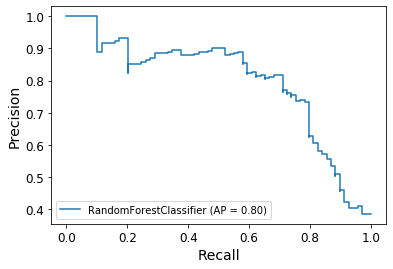

In [32]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(forest_clf,X_test_preprocessed,y_test)

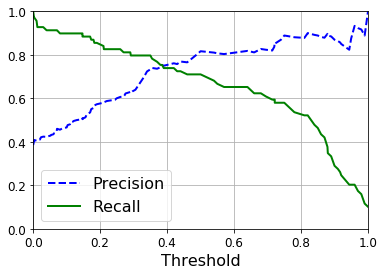

In [33]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


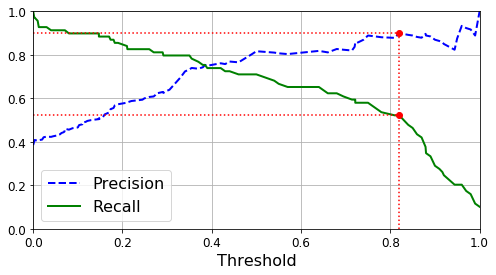

In [34]:

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([0, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([0, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                         # Not shown
plt.show()

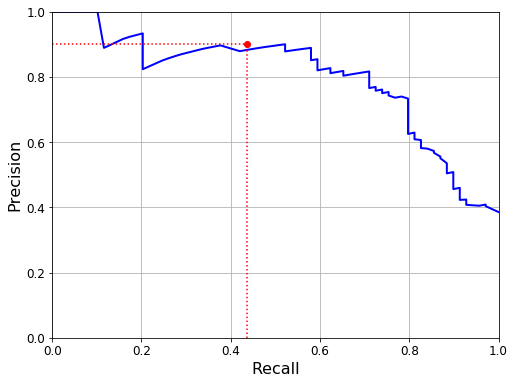

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")

plt.show()

## 5. Fine-Tune the XGBoost Model

In [36]:
# hyperparameters tuning with cross-validation
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

xgb_clf = XGBClassifier()


In [37]:
from scipy.stats import randint

params = {        
        'objective': ['binary:logistic'], 
        'random_state': [42],
        'n_estimators': np.arange(50, 200, 10).tolist(),
        'max_depth': randint(low=3, high=8),
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0,3],
        'gamma': [0, 0.25, 0.5, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        
        }
"""
param_grid = {
        'n_estimators': [100],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0,3],
        'gamma': [0, 0.25, 0.5, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        }

"""


"\nparam_grid = {\n        'n_estimators': [100],\n        'max_depth': [6, 10, 15, 20],\n        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0,3],\n        'gamma': [0, 0.25, 0.5, 1.0],\n        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],\n        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],\n        }\n\n"

In [38]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits= 3, 
                      shuffle = True, 
                      random_state = 42)

rs_cv = RandomizedSearchCV(xgb_clf,param_distributions=params,
                          n_iter = 10,
                          scoring = 'roc_auc',
                          cv = skf.split(X_train,y_train),
                          random_state=42
                          )

rs_cv.fit(X_train_preprocessed,y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe091df81d0>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_wei...
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0],
                                        'n_estimators': [50, 60, 70, 80, 90,
               

In [39]:
print('\n Best estimator:')
print(rs_cv.best_estimator_)
print('\n Best Auc')
print(rs_cv.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(rs_cv.best_params_)

results = pd.DataFrame(rs_cv.cv_results_)[['params', 
                                           'mean_test_score',
                                           'rank_test_score']].sort_values('rank_test_score')


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=7.0, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1.0, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best Auc
0.7439092451672826

 Best hyperparameters:
{'colsample_bylevel': 1.0, 'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 110, 'objective': 'binary:logistic', 'random_state': 42, 'reg_lambda': 1.0, 'subsample': 0.7}


In [40]:
results

,params,mean_test_score,rank_test_score
0,"{'colsample_bylevel': 1.0, 'colsample_bytree':...",0.871955,1
8,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",0.870393,2
7,"{'colsample_bylevel': 1.0, 'colsample_bytree':...",0.868176,3
3,"{'colsample_bylevel': 0.9, 'colsample_bytree':...",0.864415,4
6,"{'colsample_bylevel': 0.9, 'colsample_bytree':...",0.855516,5
2,"{'colsample_bylevel': 0.7, 'colsample_bytree':...",0.850901,6
9,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",0.848822,7
4,"{'colsample_bylevel': 0.7, 'colsample_bytree':...",0.823653,8
1,"{'colsample_bylevel': 1.0, 'colsample_bytree':...",0.500000,9
5,"{'colsample_bylevel': 0.6, 'colsample_bytree':...",0.500000,9


In [41]:
rs_cv.best_params_

{'colsample_bylevel': 1.0,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 7.0,
 'n_estimators': 110,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_lambda': 1.0,
 'subsample': 0.7}

In [42]:
get_test_auc(rs_cv.best_estimator_,X_test_preprocessed,y_test)

0.8438735177865613

In [43]:
# Full pipeline with data prep and model training

from sklearn.feature_selection import SelectPercentile, chi2

full_pipeline_with_predictor = Pipeline([
        ("preparation", column_trans),
        ('feature_selection', SelectPercentile(chi2, percentile=100)),
        ("model", XGBClassifier(**rs_cv.best_params_))
    ])



In [44]:
full_pipeline_with_predictor.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('num_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                          

In [45]:
get_test_auc(full_pipeline_with_predictor,X_test,y_test)

0.8438735177865613

In [46]:

# Grid search on turning pipeline, experiment the preprocessing parames
param_grid =[{
    'feature_selection__percentile': np.arange(50, 110, 10).tolist(),
    #'model__n_estimators': np.arange(50, 200, 10).tolist(),
    #'model__max_depth': randint(low=3, high=8),
}]

In [47]:

rs_cv_full_pipeline = RandomizedSearchCV(full_pipeline_with_predictor,
                                         param_distributions=param_grid,
                                          n_iter = 20,
                                          scoring = 'roc_auc',
                                          cv = skf.split(X_train,y_train),
                                          random_state=42)


In [48]:
rs_cv_full_pipeline.fit(X_train,y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe092139250>,
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preparation',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('num_imputer',
                                                                                                SimpleImputer(add_indicator=False,
           

In [49]:
rs_cv_full_pipeline.best_params_

{'feature_selection__percentile': 80}

In [50]:
pd.DataFrame(rs_cv_full_pipeline.cv_results_)[['params', 
                                           'mean_test_score',
                                           'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
3,{'feature_selection__percentile': 80},0.872453,1
1,{'feature_selection__percentile': 60},0.872164,2
5,{'feature_selection__percentile': 100},0.871846,3
2,{'feature_selection__percentile': 70},0.871347,4
4,{'feature_selection__percentile': 90},0.870583,5
0,{'feature_selection__percentile': 50},0.868197,6


In [51]:
final_model_full_pipeline = rs_cv_full_pipeline.best_estimator_

In [52]:
feat_ind = final_model_full_pipeline.named_steps['feature_selection'].get_support(indices=True)



In [53]:
feat_ind

array([0, 1, 3, 4, 5, 6, 7, 9])

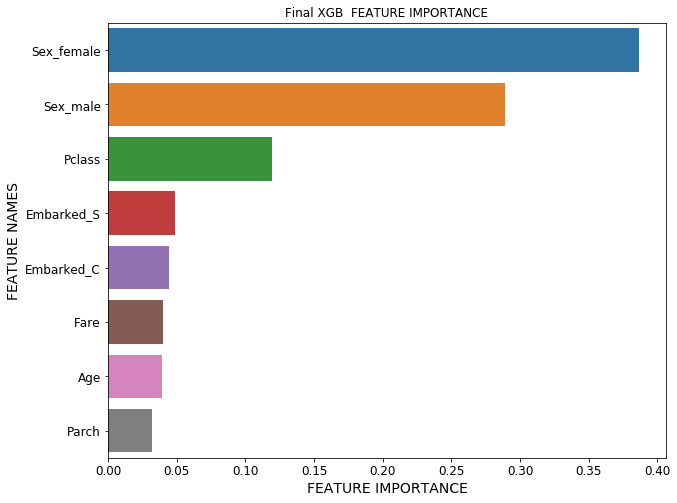

In [54]:

plot_feature_importance(final_model_full_pipeline.named_steps['model'].feature_importances_,
                        X_train_preprocessed.columns[feat_ind],
                        "Final XGB ")


## 6. Scoring New Data

In [55]:
y_pred = final_model_full_pipeline.predict_proba(X_test)

In [56]:
get_test_auc(final_model_full_pipeline,X_test,y_test)

0.8332674571805007

In [57]:
auc_comp = pd.DataFrame({'y_test':y_test.to_numpy(),
                        'y_pred_baseline':y_pred_baseline[:,1],
                        'y_pred_final':y_pred[:,1]})

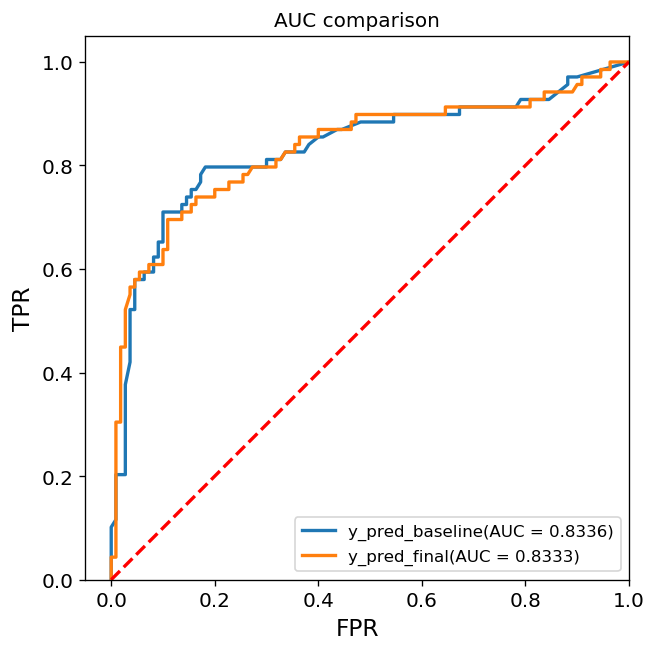

In [58]:
plot_roc_auc_comp(df=auc_comp,
                  y='y_test',
                  pred=['y_pred_baseline','y_pred_final'])

## 7. Save the Artifacts

In [59]:
import joblib

joblib.dump(final_model_full_pipeline,data_folder+'final_model.bin')

['/Users/rsun/projects/data/datasets/titanicfinal_model.bin']

In [60]:
final_model_loaded = joblib.load(data_folder+'final_model.bin')

In [61]:
final_model_loaded.predict_proba(X_test)

get_test_auc(final_model_loaded,X_test,y_test)

0.8332674571805007

## 8. Interpretation

In [62]:
import joblib

In [63]:
final_model_loaded = joblib.load(data_folder+'final_model.bin')

In [64]:
import shap

ModuleNotFoundError: No module named 'shap'